In [23]:
import torch

# Data Preparation

In [52]:
from pathlib import Path

from torchvision import transforms, datasets

train_data = datasets.Imagenette(
    "../data/imagenette",
    split="train",
    size="160px",
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.CenterCrop(128),
        ]
    ),
)
valid_data = datasets.Imagenette(
    "../data/imagenette",
    split="val",
    size="160px",
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.CenterCrop(128),
        ]
    ),
)
train_data.classes, len(train_data.classes)

([('tench', 'Tinca tinca'),
  ('English springer', 'English springer spaniel'),
  ('cassette player',),
  ('chain saw', 'chainsaw'),
  ('church', 'church building'),
  ('French horn', 'horn'),
  ('garbage truck', 'dustcart'),
  ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
  ('golf ball',),
  ('parachute', 'chute')],
 10)

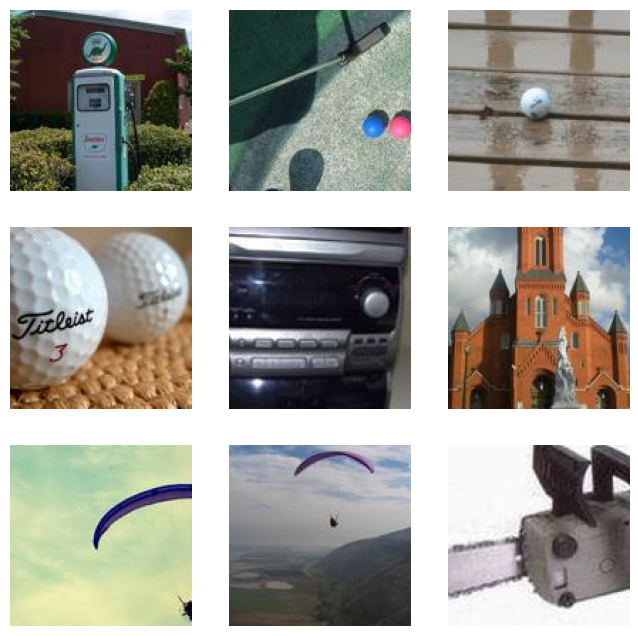

In [26]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [27]:
img, label = train_data[0]
img.shape

torch.Size([3, 128, 128])

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_data, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)
test_dataloader = DataLoader(
    valid_data, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)


# CNN

In CNN, we used stride-2 layers to reduce the activation maps. This has two constraints:
1. we need many layers as the size of the image increase
2. the model won't apply on sizes other than the original size of the training data

To solve Q1, we uses **average pooling**, which takes the average of every grid on activation map. In CNN, this is represented by `nn.AdaptiveAvgPool2d`. This will reduce the size of the activations dramatically.

In [ ]:
import torch.nn as nn


def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks // 2)]
    if act:
        layers.append(nn.BatchNorm2d(nf))
    layers.append(nn.ReLU())  # batch norm
    return nn.Sequential(*layers)


cnn = nn.Sequential(
    conv(3, 16),  # 63 x 63
    conv(16, 32),  # 31 x 31
    conv(32, 64),  # 15 x 15
    conv(64, 128),  # 7 x 7
    conv(128, 256),  # 3 x 3
    nn.AdaptiveAvgPool2d(1),  # 1 x 1
    nn.Flatten(),
    nn.Linear(256, len(train_data.classes)),
)

It turns out, this is where we need to add batch norm. The training results stagnates without it:

TODO: link to cnn
```
epoch 0, train loss: 2.3026 validation loss 2.3016691669341056
epoch 1, train loss: 2.2945 validation loss 2.2914406868719284
epoch 2, train loss: 2.2961 validation loss 2.2887864881946194
epoch 3, train loss: 2.2999 validation loss 2.303145508612356
epoch 4, train loss: 2.3023 validation loss 2.3023520823447936
```

In the CNN, we are using stride size of 2 and padding 0. So activation size after the first layer is `(n + 2*pad - ks)//stride + 1 = (128 - 3) // 2 + 1 = 63`. The rest of the activation is shown in the comments. The average pooling will reduce the dimension to 1 x 1 and `Flatten` will get rid off those dimensions 64 x 256 (1 x 1 at the end disappeared). Finally we use a linear layer to turn size 256 into 10, which is the number of classes/categories in the image data.

Because this dataset is a relatively large, we will perform the training on GPU instead.

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = cnn.to(device)

In [57]:
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)
yb = yb.to(device)
# run one batch
xb.shape, cnn(xb).shape

(torch.Size([128, 3, 128, 128]), torch.Size([128, 10]))

We will train the cnn as a benchmark for ResNet.

In [ ]:
import torch.nn.functional as F

epochs = 5
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05, steps_per_epoch=len(train_dataloader), epochs=epochs
)
torch.backends.cudnn.benchmark = True  # good if input sizes are consistent


def train(model, epochs, train_loader, valid_loader):
    for epoch in range(epochs):
        epoch_loss = torch.zeros((), device=device)
        batch_num = 0
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            pred = model(xb)
            loss = F.cross_entropy(pred, yb)
            loss.backward()
            optimizer.step()
            scheduler.step()  # Add scheduler step here
            optimizer.zero_grad()
            epoch_loss += loss.item()
            batch_num += 1  # number of batches within a epoch
        avg_loss = epoch_loss / batch_num
        model.eval()
        with torch.no_grad():
            batch_num_valid = 0
            valid_loss = 0
            for xb, yb in valid_loader:
                # Move data to GPU
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                valid_loss += F.cross_entropy(model(xb), yb).item()
                batch_num_valid += 1
        print(f"epoch {epoch}, train loss: {avg_loss:.4f}")
        print("validation loss", valid_loss / batch_num_valid)


train(cnn, epochs, train_dataloader, test_dataloader)

epoch 0, train loss: 1.9346
validation loss 6.488018466580298
epoch 1, train loss: 1.4490
validation loss 2.014465593522595
epoch 2, train loss: 1.1623
validation loss 3.7883222256937334
epoch 3, train loss: 0.9904
validation loss 1.0996484679560508
epoch 4, train loss: 0.8311
validation loss 0.9774862277892328


# ResNet
The motivating idea of ResNet is the observation that nn with fewer layers produces better training results than those with more.This is because larger/bigger nn doesn't always lead to better results because the larger nn might drift away from the previous, smaller nn. Therefore we need a way to make the larger function contains the smaller, previous function. This is done through an **identity function**.

The intuition of ResNet is the following. Suppose the goal of a nn is to learn $f(x)$, instead of learning it directly, we transform it into $f(x) = g(x) + x$. Now the goal becomes learning the **residual mapping** $g(x) = f(x)- x$. Furthermore, if we make $f(x)$ an identity function, we got $g(x) = f(x) - x = 0$, which is easy to learn.

As shown above, in CNN, our definition of a convolution layer is a convolution layer plus a activation function, and a optional batch normalization. In ResNet, we add an identity branch $x$ to every other weight layer. This structure is called **Residual Block**. As shown in the figure below (the function def. is different from the paragraph above), which comes from the paper, the path on the left is $g(x)$, where g(x) is `conv2(conv1(x))`. The training goal is to learn $F(x)$ as opposed to $F(x) + x$.

TODO: add resblock

Based on our working definition, our initial definition resnet block can be:
```{python}
class BatchZeroNorm(nn.Module):
    def __init__(self, nf, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.bn = nn.BatchNorm2d(nf)

    def forward(self, x):
        x = x - x.mean(dim=0, keepdim=True)   # zero-center across batch
        return self.bn(x)

class ResBlock(nn.Module):
    def __init__(self, ni, nf):

        self.convs = nn.Sequential(
            nn.Sequential(nn.Conv2d(ni, nf, kernel_size = 3,stride = 2, padding = 1 ),
                          nn.BatchNorm2d(nf),
                          nn.ReLU()),
            nn.Sequential(nn.Conv2d(ni, nf, kernel_size = 3,stride = 2, padding = 1 ),
                          nn.BatchZeroNorm(nf),
                          nn.ReLU()),)
        
    def forward(self, x): return x + self.convs(x)
```
the problem here is that to perform the forward step, `x` and `self.conv` must have the same shape, that means we can't shrink the size of the convolution layers.

To reduce the size of the `Resblock`, we need to change the shape of the identity function $x$ to match that of the $F(x)$. Similar to passing thru a convolution layer, both size and the channel # of the activations need to shrink. For size differences, we use **average pooling** of size 2 to produce the same effect as stride size 2, for channel diff, we use convolution of size 1 kernel, which reproduces the original size but change the channels, which is what we want in identity function.


In [ ]:
class BatchZeroNorm(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.bn = nn.BatchNorm2d(nf)
        # Initialize gamma (weight) to zero
        nn.init.zeros_(self.bn.weight)

    def forward(self, x):
        return self.bn(x)


def _conv_block(ni, nf, stride):
    seq = nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(nf),
        nn.ReLU(inplace=True),
        nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1, bias=False),
        BatchZeroNorm(nf),  # no activation here
    )
    return seq


class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride)
        self.idconv = (
            nn.Identity()
            if ni == nf
            else nn.Sequential(
                nn.Conv2d(ni, nf, kernel_size=1, bias=False),  # size 1 kernel
                nn.BatchNorm2d(nf),  # no activation
            )
        )
        self.pool = (
            nn.Identity()
            if stride == 1
            else nn.AvgPool2d(stride, ceil_mode=True)  # average pool
        )

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

Now we are ready to train our first ResNet model. We use the same training setup as the cnn, only change the model architecture. In our ResNet model, we double the amount of layers by adding two `ResBlock` in a `conv`. 

As shown in the stats, the final validation loss is slightly worse than cnn (in the fastai book, resnet performs slightly better than cnn).

In [ ]:
def conv(ni, nf, ks=3, act=True):
    return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf, nf))


resnet = nn.Sequential(
    conv(3, 16),  # 63 x 63
    conv(16, 32),  # 31 x 31
    conv(32, 64),  # 15 x 15
    conv(64, 128),  # 7 x 7
    conv(128, 256),  # 3 x 3
    nn.AdaptiveAvgPool2d(1),  # 1 x 1
    nn.Flatten(),
    nn.Linear(256, len(train_data.classes)),
)
resnet = resnet.to(device)
optimizer = torch.optim.SGD(
    resnet.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05, steps_per_epoch=len(train_dataloader), epochs=epochs
)
train(resnet, epochs, train_dataloader, test_dataloader)

epoch 0, train loss: 2.0216
validation loss 1.9503359525434432
epoch 1, train loss: 1.7200
validation loss 5.439028878365794
epoch 2, train loss: 1.4076
validation loss 2.5118558176102175
epoch 3, train loss: 1.1564
validation loss 1.1678673028945923
epoch 4, train loss: 0.9587
validation loss 0.9862854288470361


# Improve ResNet


Now we will improve on the basic resnet by implementing the [bag of tricks](https://arxiv.org/abs/1812.01187) paper. This is an improved version of ResNet, where the first layers are convolution layers followed by a max pooling layer. This is called *stem* of the resnet.

The following passage is taken from the book:
> The reason that we have a stem of plain convolutional layers, instead of ResNet blocks, is based on a very important insight about all deep convolutional neural networks: the vast majority of the computation occurs in the early layers. Therefore, we should keep the early layers as fast and simple as possible.
>
> To see why so much computation occurs in the early layers, consider the very first convolution on a 128-pixel input image. If it is a stride-1 convolution, then it will apply the kernel to every one of the 128×128 pixels. That's a lot of work! In the later layers, however, the grid size could be as small as 4×4 or even 2×2, so there are far fewer kernel applications to do.
>
> On the other hand, the first-layer convolution only has 3 input features and 32 output features. Since it is a 3×3 kernel, this is 3×32×3×3 = 864 parameters in the weights. But the last convolution will have 256 input features and 512 output features, resulting in 1,179,648 weights! So the first layers contain the vast majority of the computation, but the last layers contain the vast majority of the parameters.

We redefine our ResNet with this new feature:

In [ ]:
def conv_layer(
    ni, nf, ks=3, stride=1, padding=None, bias=None, act_cls=True, batch_zero=False
):
    if padding is None:
        padding = ks // 2
    seq = [nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias)]
    seq.append(BatchZeroNorm(nf)) if batch_zero else seq.append(nn.BatchNorm2d(nf))
    if act_cls:
        seq.append(nn.ReLU(inplace=True))
    return nn.Sequential(*seq)


def resnet_stem(sizes):
    return [
        conv_layer(sizes[i], sizes[i + 1], stride=2 if i == 0 else 1)
        for i in range(len(sizes) - 1)
    ] + [nn.MaxPool2d(3, 2, 1)]


class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = resnet_stem([3, 32, 32, 64])
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1, 5):
            self.block_szs[i] *= expansion
        blocks = [self._make_layer(i, n) for i, n in enumerate(layers)]
        super().__init__(
            *stem,
            *blocks,
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(self.block_szs[-1], n_out),
        )

    def _make_layer(self, idx, n_layers):
        stride = 1 if idx == 0 else 2
        ch_in, ch_out = self.block_szs[idx : idx + 2]
        return nn.Sequential(
            *[
                ResBlock(ch_in if i == 0 else ch_out, ch_out, stride if i == 0 else 1)
                for i in range(n_layers)
            ]
        )

The various versions of the models (ResNet-18, -34, -50, etc.) just change the number of blocks in each of those groups. This is the definition of a ResNet-18. After training, it looks like it is a significant improvement compared to our cnn and initial resnet. 

In [ ]:
rn = ResNet(len(train_data.classes), [2, 2, 2, 2])
rn = rn.to(device)
optimizer = torch.optim.SGD(rn.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05, steps_per_epoch=len(train_dataloader), epochs=epochs
)
train(rn, epochs, train_dataloader, test_dataloader)

epoch 0, train loss: 1.7921
validation loss 3.277297865959906
epoch 1, train loss: 1.2654
validation loss 2.529502760979437
epoch 2, train loss: 1.0690
validation loss 1.2660500657173894
epoch 3, train loss: 0.9034
validation loss 1.4320512221705528
epoch 4, train loss: 0.7522
validation loss 0.8087952483084894


Because the model now is a lot deeper, we can use a bigger dataset to leverage the power of the model. We use the 320px version of the dataset and scale it to 224px.

In [40]:
train_data = datasets.Imagenette(
    "../data/imagenette",
    split="train",
    size="320px",
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.CenterCrop(224),
        ]
    ),
)
valid_data = datasets.Imagenette(
    "../data/imagenette",
    split="val",
    size="320px",
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.CenterCrop(224),
        ]
    ),
)
train_data.classes, len(train_data.classes)

([('tench', 'Tinca tinca'),
  ('English springer', 'English springer spaniel'),
  ('cassette player',),
  ('chain saw', 'chainsaw'),
  ('church', 'church building'),
  ('French horn', 'horn'),
  ('garbage truck', 'dustcart'),
  ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
  ('golf ball',),
  ('parachute', 'chute')],
 10)

In [ ]:
train_dataloader = DataLoader(
    train_data, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)
test_dataloader = DataLoader(
    valid_data, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

We are going to make the model more than 50 layers deep (ResNet-50). And we will use **bottleneck layers** introduced in the ResNet paper to to stack 3 convolutions before applying an identity function, two 1 x 1 conv at beginning and end and a 3 x 3 conv in the middle. This modified ResBlock construction actually computer faster than the original, since 1 x 1 conv compute fast. This allows us to add more layers without adding much computer time. With bottleneck layers, we can capture more channels (256 vs 64), as shown in the figure. 

TODO: add figure

We redefine the `_conv_block` function below, which is called by `ResBlock` when we construct the ResNet.

In [ ]:
def _conv_block(ni, nf, stride):
    return nn.Sequential(
        conv_layer(ni, nf // 4, 1),
        conv_layer(nf // 4, nf // 4, stride=stride),
        conv_layer(nf // 4, nf, 1, act_cls=None, batch_zero=True),
    )

The function above will be called automatically when we construct a new ResNet. Now we are ready to start train or improved model. As shown in the training results below, the loss is significantly smaller, and we are able to achieve 83% of accuracy, not bad.

In [ ]:
epochs = 20
rn = ResNet(len(train_data.classes), [3, 4, 6, 3], 4)
rn = rn.to(device)
optimizer = torch.optim.SGD(rn.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05, steps_per_epoch=len(train_dataloader), epochs=epochs
)
train(rn, epochs, train_dataloader, test_dataloader)

epoch 0, train loss: 1.7322
validation loss 1.9429067411730367
epoch 1, train loss: 1.3540
validation loss 2.3314049782291537
epoch 2, train loss: 1.2455
validation loss 1.6011053554473385
epoch 3, train loss: 1.1375
validation loss 1.5402678597357966
epoch 4, train loss: 1.0417
validation loss 2.330352960094329
epoch 5, train loss: 0.9342
validation loss 1.415866373046752
epoch 6, train loss: 0.8855
validation loss 1.1671597361564636
epoch 7, train loss: 0.8057
validation loss 1.0296350467589594
epoch 8, train loss: 0.7479
validation loss 1.4604182243347168
epoch 9, train loss: 0.6979
validation loss 3.526347114193824
epoch 10, train loss: 0.6632
validation loss 0.9652688926266085
epoch 11, train loss: 0.6346
validation loss 1.3261786968477312
epoch 12, train loss: 0.5648
validation loss 0.8353007724208217
epoch 13, train loss: 0.5293
validation loss 0.8034363504379026
epoch 14, train loss: 0.4802
validation loss 0.8441745369665085
epoch 15, train loss: 0.4384
validation loss 0.670680

In [ ]:
rn.eval()
valid_loss = 0.0
valid_correct = 0
valid_total = 0

with torch.no_grad():
    for xb, yb in test_dataloader:
        xb = xb.to(device)
        yb = yb.to(device)

        out = rn(xb)
        valid_loss += F.cross_entropy(out, yb).item()

        preds = out.argmax(dim=1)
        valid_correct += (preds == yb).sum().item()
        valid_total += yb.size(0)

avg_valid_loss = valid_loss / max(1, len(test_dataloader))
valid_acc = 100.0 * valid_correct / max(1, valid_total)

print(f"valid loss {avg_valid_loss:.4f} | valid acc {valid_acc:.2f}%")

valid loss 0.5438 | valid acc 83.13%
